In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink

from basic_tools import *

In [2]:
final_aa_path,final_plink_path,final_plink_aa_path

('data/genotype/4_merge/KCHIP_HLA.hg18.intersection_HAN.LABELED.NoSameAllele.bMarkers.2field.saveRareAllele.beagle5.1.AGM.bgl.phased.QC.aa',
 'data/genotype/4_merge/KCHIP_HLA_SNP_1000G_merged',
 'data/genotype/4_merge/KCHIP_HLA_AA_SNP_1000G_merged')

# load plink, aa and check integrity

In [3]:
plink_path=final_plink_path
plink_aa_path=final_plink_aa_path
aa_path=final_aa_path

In [4]:
plink=PyPlink(plink_path)
fam=plink.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
bim=plink.get_bim()

In [5]:
plink_aa=PyPlink(plink_aa_path)
fam_aa=plink_aa.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
bim_aa=plink_aa.get_bim()

In [6]:
assert (fam['IID']!=fam_aa['IID']).sum()==0

In [7]:
f=open(aa_path,'r');aa_ind=f.readline().strip().split(' ')[2:];f.close()

In [8]:
aa_ind_1=[aa_ind[i] for i in range(0,len(aa_ind),2)]
aa_ind_2=[aa_ind[i+1] for i in range(0,len(aa_ind),2)]

In [9]:
assert (fam['IID']!=aa_ind_1).sum()==0
assert (fam['IID']!=aa_ind_2).sum()==0

# load phenotype and check integrity

In [10]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')

In [11]:
phenotypes=phenotypes.set_index('ID').loc[fam.IID]
phenotypes.shape

(125673, 137)

In [12]:
assert (phenotypes.index!=fam['IID']).sum()==0

In [96]:
plink_aa.get_geno_marker('rs9258102')==1

array([False, False, False, ..., False, False,  True])

In [120]:
def cal_maf(dosage_array):
    maf=((dosage_array==1).sum()+2*(dosage_array==2).sum())/\
         (2*(dosage_array!=-1).sum())
    return maf

maf_list_list=[]
for idx_bim,(SNP,row) in enumerate(bim_aa.iterrows()):
    maf_list=[]
    dosage=plink_aa.get_geno_marker(SNP)
    maf_list.append(cal_maf(dosage))
    for cohort in range(1,3+1):
        cohort_dosage=dosage[phenotypes['cohort']==cohort]
        #print('total: {:5d} -1:{:5d} 0:{:5d} 1:{:5d} 2:{:5d}'.format(len(cohort_dosage),(cohort_dosage==-1).sum(),(cohort_dosage==0).sum(),(cohort_dosage==1).sum(),(cohort_dosage==2).sum()))
        maf_list.append(cal_maf(cohort_dosage))
    maf_list_list.append(maf_list)

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [164]:
maf_df=pd.DataFrame(maf_list_list,index=bim_aa.index,columns=['all','AS','CT','NC'])
maf_df=maf_df[maf_df.isnull().sum(axis=1)==0]

maf_df['all']=np.where(maf_df['all']>0.5,1-maf_df['all'],maf_df['all'])
maf_df['AS']=np.where(maf_df['AS']>0.5,1-maf_df['AS'],maf_df['AS'])
maf_df['CT']=np.where(maf_df['CT']>0.5,1-maf_df['CT'],maf_df['CT'])
maf_df['NC']=np.where(maf_df['NC']>0.5,1-maf_df['NC'],maf_df['NC'])

In [165]:
maf_df['all_weighted']=(maf_df['AS']+maf_df['CT']+maf_df['NC'])/3#(maf_df['AS']*(phenotypes['cohort']==1).sum()+maf_df['CT']*(phenotypes['cohort']==2).sum()+maf_df['NC']*(phenotypes['cohort']==3).sum())/(phenotypes['cohort'].shape[0])

In [166]:
maf_df['AS_diff']=(maf_df['AS']-maf_df['all']).abs()
maf_df['CT_diff']=(maf_df['CT']-maf_df['all']).abs()
maf_df['NC_diff']=(maf_df['NC']-maf_df['all']).abs()


maf_df['AS_diff_weighted']=(maf_df['AS']-maf_df['all_weighted']).abs()
maf_df['CT_diff_weighted']=(maf_df['CT']-maf_df['all_weighted']).abs()
maf_df['NC_diff_weighted']=(maf_df['NC']-maf_df['all_weighted']).abs()



In [167]:
maf_df

,all,AS,CT,NC,all_weighted,AS_diff,CT_diff,NC_diff,AS_diff_weighted,CT_diff_weighted,NC_diff_weighted
snp,,,,,,,,,,,
6:28000361_T/C,0.094969,0.093335,0.094550,0.097821,0.095235,0.001634,0.000419,0.002852,0.001900,0.000685,0.002586
6:28000610_C/A,0.094949,0.093269,0.094530,0.097821,0.095207,0.001679,0.000419,0.002872,0.001937,0.000677,0.002614
6:28001003_A/C,0.088858,0.086368,0.088550,0.091474,0.088797,0.002490,0.000308,0.002616,0.002429,0.000247,0.002677
6:28001033_T/C,0.309947,0.309780,0.309543,0.312133,0.310486,0.000167,0.000404,0.002186,0.000705,0.000942,0.001647
6:28001610_T/C,0.309939,0.309780,0.309533,0.312133,0.310482,0.000159,0.000406,0.002194,0.000702,0.000949,0.001651
...,...,...,...,...,...,...,...,...,...,...,...
6:34997188_C/T,0.088209,0.088603,0.087940,0.089464,0.088669,0.000394,0.000270,0.001255,0.000066,0.000729,0.000795
6:34997259_G/A,0.010953,0.012160,0.010831,0.011107,0.011366,0.001207,0.000122,0.000154,0.000794,0.000535,0.000259
6:34997606_T/A,0.408628,0.401144,0.409786,0.405564,0.405498,0.007484,0.001158,0.003064,0.004354,0.004288,0.000066


Text(0.5, 1.0, 'difference of variants MAF between cohorts ( abs(MAF_cohort-avg(MAF_cohort)) )')

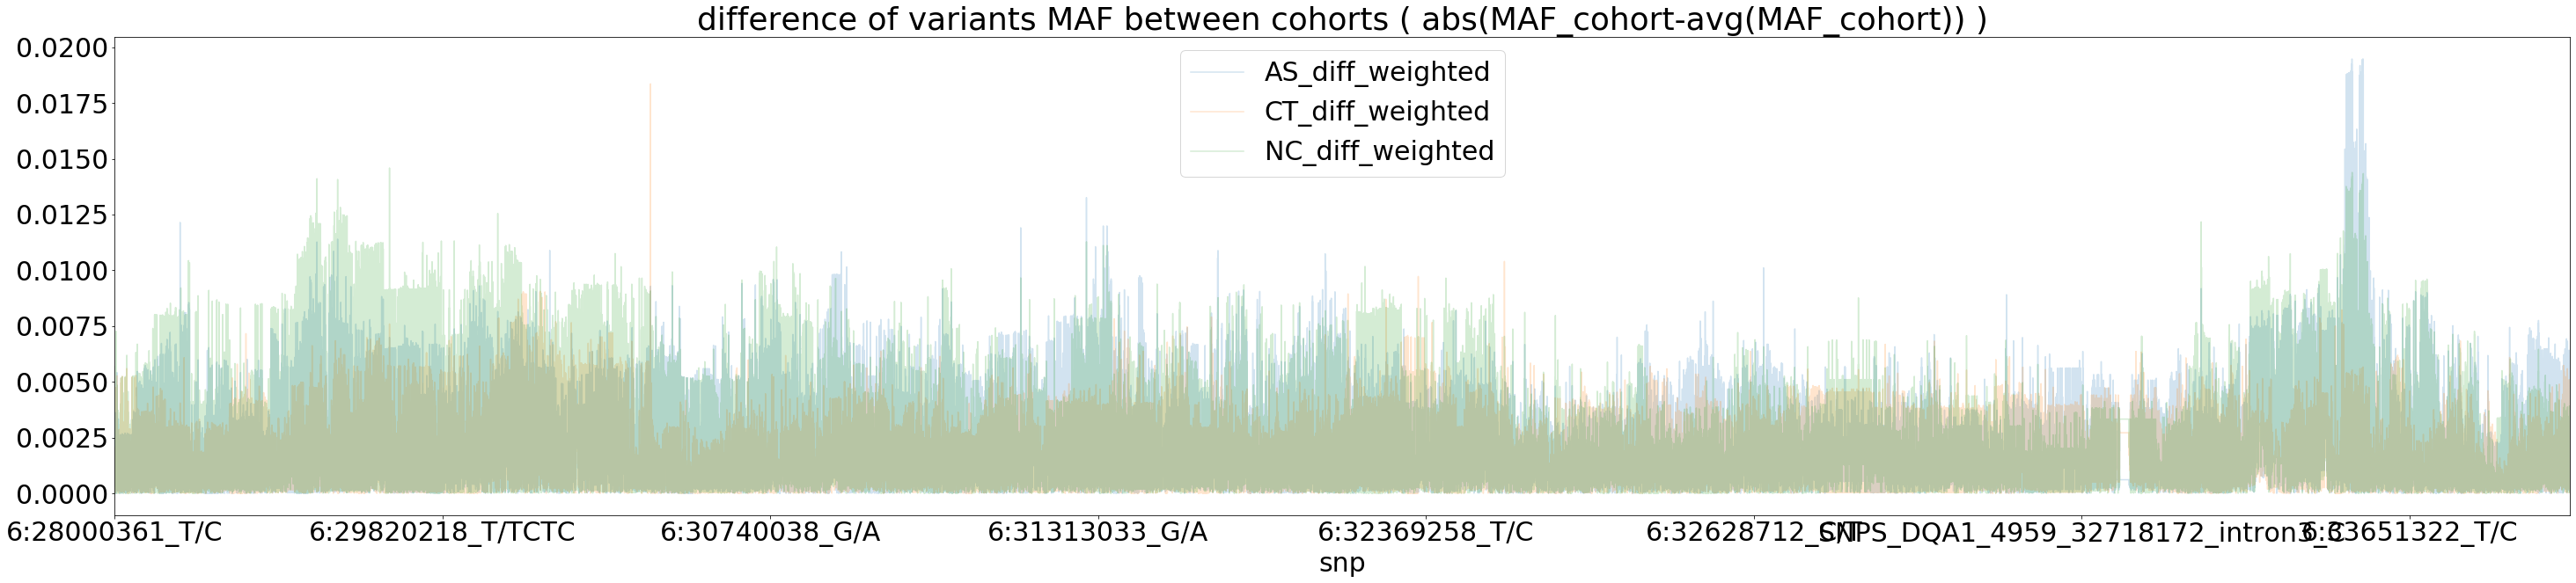

In [168]:
plt.rcParams["figure.figsize"] = (50,10)
plt.rcParams["font.size"]=30

maf_df[['AS_diff_weighted','CT_diff_weighted','NC_diff_weighted']].plot(alpha=0.2)
plt.title("difference of variants MAF between cohorts ( abs(MAF_cohort-avg(MAF_cohort)) )")

In [169]:
maf_df['AS'].mean(),maf_df['AS'].min(),maf_df['AS'].max()

(0.19483053254227672, 0.004732483239121861, 0.5)

In [170]:
maf_df['CT'].mean(),maf_df['CT'].min(),maf_df['CT'].max()

(0.1946544550292758, 0.004921388880484878, 0.4999848727800805)

In [171]:
maf_df['NC'].mean(),maf_df['NC'].min(),maf_df['NC'].max()

(0.19395682067393166, 0.005103929761464008, 0.5)

In [172]:
maf_df['AS_diff_weighted'].mean(),maf_df['AS_diff_weighted'].min(),maf_df['AS_diff_weighted'].max()

(0.0022412417310651704, 4.579547852046062e-10, 0.019479151573028652)

In [173]:
maf_df['CT_diff_weighted'].mean(),maf_df['CT_diff_weighted'].min(),maf_df['CT_diff_weighted'].max()

(0.001673300881159929, 1.2356453422956992e-07, 0.018359628370642617)

In [174]:
maf_df['NC_diff_weighted'].mean(),maf_df['NC_diff_weighted'].min(),maf_df['NC_diff_weighted'].max()

(0.002263989566338635, 6.980417109961334e-08, 0.01458894060723423)

MAF AS>=CT>NC

In [175]:
maf_df.shape

(74904, 11)

In [183]:
(maf_df['AS']<0.05).sum(),(maf_df['AS']<0.01).sum(),(maf_df['AS']<0.005).sum()

(15116, 237, 3)

In [186]:
(maf_df['CT']<0.05).sum(),(maf_df['CT']<0.01).sum(),(maf_df['CT']<0.005).sum()

(15187, 210, 2)

In [187]:
(maf_df['NC']<0.05).sum(),(maf_df['NC']<0.01).sum(),(maf_df['NC']<0.005).sum()

(15357, 160, 0)

In [181]:
(maf_df==0).sum()

all                 0
AS                  0
CT                  0
NC                  0
all_weighted        0
AS_diff             0
CT_diff             0
NC_diff             0
AS_diff_weighted    0
CT_diff_weighted    0
NC_diff_weighted    0
dtype: int64